In [1]:
import pandas as pd
import numpy as np
from numba import njit

#This is the URL of the file
url = "https://onedrive.live.com/download?resid=4E16D53638D067A9%21337206&authkey=!APxYFBiUDvn51MI" #REMEMBER to change embed to download;

spy_data = pd.read_csv(url, parse_dates = True, index_col=0) #it's a time series data, so I'm setting the index to be the first column

In [5]:
#Create a backtesting function that backtests based on Bollinger Bands


close = spy_data["close"].to_numpy() #We transform the close prices into a numpy array


@njit(fastmath=True, parallel=True)
def backtest_bollinger_bands(data, window, num_std_devs):
    
    
    #-------------------Bollinger Bands-------------------

    #We calculate the rolling mean:
    middle_band = np.zeros(len(data)) #We create an array of zeros to store the rolling mean
    for i in range(window, len(data)):
        middle_band[i] = np.mean(data[i-window:i]) #We calculate the rolling mean for each day

    #We calculate the rolling standard deviation:
    rolling_std = np.zeros(len(data))
    for i in range(window, len(data)):
        rolling_std[i] = np.std(data[i-window:i]) #We calculate the rolling standard deviation for each day

    #We calculate the upper and lower bands:
    upper_band = middle_band + num_std_devs * rolling_std
    lower_band = middle_band - num_std_devs * rolling_std




    #Strategy's logic:
    positions = np.zeros(len(close)) #We create an array of zeros to store the positions

    for i in range(window, len(close)): #from the second row to the last row of the data
        if close[i] < lower_band[i] and positions[i-1] == 0:
            positions[i] = 1 #long if the price is below the lower band and we don't have a position
        elif close[i] > upper_band[i] and positions[i-1] == 0:
            positions[i] = -1 #short if the price is above the upper band and we don't have a position
        elif close[i] > middle_band[i] and positions[i-1] == 1:
            positions[i] = 0 #close long position if the price is above the middle band and we have a long position
        elif close[i] < middle_band[i] and positions[i-1] == -1:
            positions[i] = 0 #close short position if the price is below the middle band and we have a short position
        else:
            positions[i] = positions[i-1] #carry on with the previous position if none of the conditions are met;

    #We calculate the returns of the strategy:
    
    market_returns = np.zeros(len(data)) #We create an array of zeros to store the market returns
    for i in range(1, len(data)):
        market_returns[i] = (data[i] - data[i-1]) / data[i-1] #We calculate the market returns for each day
    
    strategy_returns = np.zeros(len(data)) #We create an array of zeros to store the strategy returns
    for i in range(1, len(data)):
        strategy_returns[i] = positions[i-1] * market_returns[i] #We calculate the strategy returns for each day, shifting the positions array by 1 day
    
    cumulative_returns = np.cumprod(1 + strategy_returns) #We calculate the cumulative returns of the strategy


    return cumulative_returns


v1 = backtest_bollinger_bands(close, 20, 2)

#TOTAL ITERATION TIME: 12 MINUTES AND 23 SECONDS!

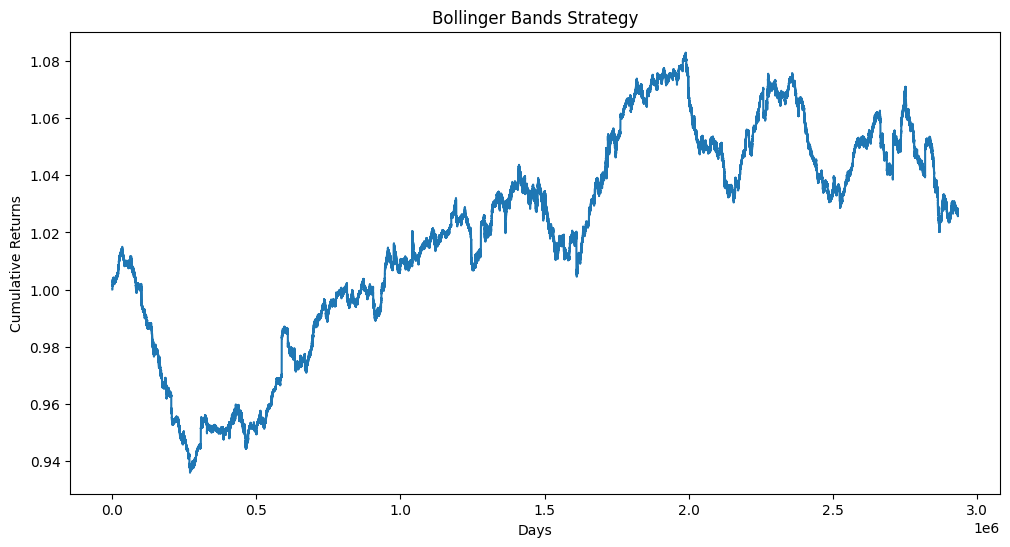

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(v1)
plt.title("Bollinger Bands Strategy on SPY with 1 second data")
plt.ylabel("Cumulative Returns")
plt.xlabel("Days")
plt.show()